<a href="https://colab.research.google.com/github/Followb1ind1y/Distracted_Driver_Detection_Project/blob/main/State_Farm_Distracted_Driver_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **State Farm Distracted Driver Detection Project**

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import matplotlib.pyplot as plt

## **1. Obtaining and Organizing the Dataset**

### **1.1. Download Dataset from kaggle**

In [25]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [26]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:46<00:00, 118MB/s]
100% 4.00G/4.00G [00:46<00:00, 92.4MB/s]


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip

### **1.2. Data Visualization**

In [28]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


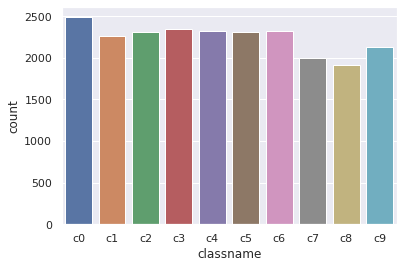

In [29]:
import seaborn as sns

# Number of images by category
sns.set_theme(style="darkgrid")
sns.countplot(x = 'classname', data=dataset)

###**1.3. Organizing the Dataset**

In [30]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import splitfolders

data_dir = '/content/imgs/train'
splitfolders.ratio(data_dir, output="output", ratio=(0.8, 0.1, 0.1))
output_dir = '/content/output'

Copying files: 22424 files [00:07, 2925.91 files/s]


## **2. Image Augmentation**

In [32]:
data_augmentation = {
    'train': transforms.Compose([
        torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

## **3. Reading the Dataset**

In [43]:
Batch_Size = 4
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(output_dir, x), 
                                                      data_augmentation[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,shuffle=True, 
                                              drop_last=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

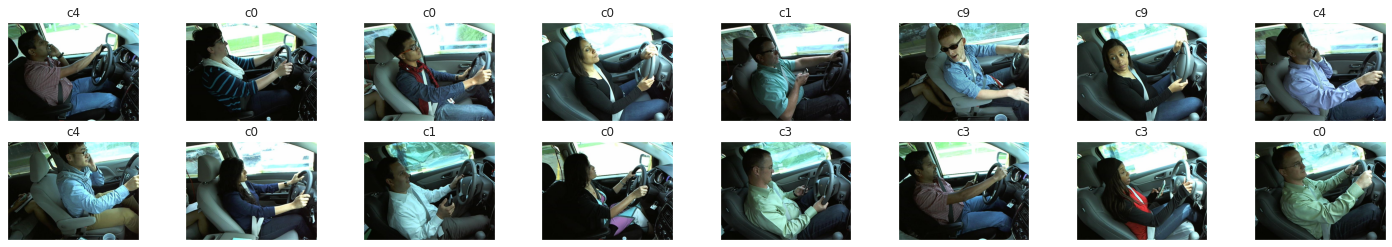

In [42]:
# Visualize some sample data from the original dataset

images, labels = next(iter(dataloaders['test']))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow((np.transpose(images[idx], (1, 2, 0))))
    ax.set_title(class_names[labels[idx]])

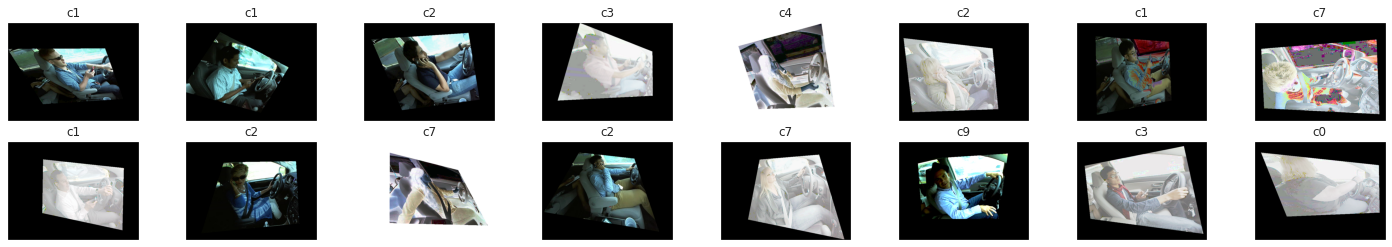

In [35]:
# Visualize some sample data after Augmentation

images, labels = next(iter(dataloaders['train']))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow((np.transpose(images[idx], (1, 2, 0))))
    ax.set_title(class_names[labels[idx]])

## **4. Defining the Model**

loss, forward, plot, training step, val step, optimizers

In [48]:
class MobileNet_V2_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'MobileNet_V2'
        
        self.cnn = models.mobilenet_v2(pretrained=True)
        self.cnn.classifier = nn.Linear(1280, 10)

    def forward(self, x):
        return self.cnn(x)

## **5. Training the Model**

prepare data, prepare model, fit, fit epoch

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    start_time = time.time()

    best_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_accs, train_losses = [], []
    val_accs, val_losses = [], []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f'Epoch {epoch}/{num_epochs - 1}', end=': ')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # training mode
            else:
                model.eval()  # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}', end=': ')

            if phase == 'train':
                scheduler.step()
                train_accs.append(epoch_acc.cpu().detach())
                train_losses.append(epoch_loss)
            else:
                val_accs.append(epoch_acc.cpu().detach())
                val_losses.append(epoch_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_dur = str(round(time.time() - epoch_start,2))
        print(f'Epoch time:  {epoch_dur // 60:.0f}m {epoch_dur % 60:.0f}s')

    time_elapsed = time.time() - start_time
    print()
    print('-' * 20)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # plot traininng curve

    train_accs, val_accs = np.array(train_accs), np.array(val_accs)
    train_losses, val_losses = np.array(train_losses), np.array(val_losses)

    plt.plot(np.arange(num_epochs, step=1), train_losses, label='Train loss')
    plt.plot(np.arange(num_epochs, step=1), train_accs, label='Train acc')
    plt.plot(np.arange(num_epochs, step=1), val_accs, label='Val acc')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [49]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

model_ft = MobileNet_V2_Model()
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date

  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [50]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9: train loss: 0.7131 acc: 0.7673: val loss: 0.1796 acc: 0.9441: Epoch time: 830.32
Epoch 1/9: 

KeyboardInterrupt: ignored